In [79]:
import numpy as np
import pandas as pd

from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb

import os

In [80]:
# ensure reproducibility.
SEED = 42

### Using colab for submission:
need to include these two code cells in order to access data

In [81]:
# path to project: Edit here to point to your Drive
drive = '/content/drive/MyDrive/'
project_dir = 'Iron_Hack/Week10_career_week/technical_challenge_DA'
COLAB_PROJECT_PATH = drive+project_dir

In [82]:
# Mount Google Drive
using_colab = False
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    # Mount Google Drive
    drive.mount('/content/drive', force_remount=True)
    using_colab = True

if using_colab and os.path.exists(COLAB_PROJECT_PATH):
    print('found colab path; redirecting to main project directory')
    os.chdir(COLAB_PROJECT_PATH)

Mounted at /content/drive
found colab path; redirecting to main project directory


In [83]:
data = pd.read_csv('Cleaned_Data/clean_gas_measurements.csv')

### Hypothesis #1 : Consumption of Fuel types are not the same

In [84]:
a = 0.05

gas_e10 = data[data.gas_type == 'E10'].fuel_consumed
gas_sp98 = data[data.gas_type == 'SP98'].fuel_consumed

stat, p_value = ttest_ind(gas_e10, gas_sp98, equal_var=False)
print(f"{stat = }, {p_value = }")
if p_value < a and stat > 0:
    print("Reject the null hypothesis: the gas consumption is not the same for SP98 and E10")
else:
    print("Fail to reject: not statistically significant enough to conclude the gas consumption is different for E10 and Sp98")

stat = 1.1348507838701907, p_value = 0.25715162660087737
Fail to reject: not statistically significant enough to conclude the gas consumption is different for E10 and Sp98


We Failed to reject the null hypothesis, so we conclude that they are probably the conumption rate

In [85]:
def corr_tri_map(df):

    data = df.copy(deep=True)

    # Encode gas type
    data['gas_type'] = np.where(data['gas_type']=='E10',1,0)

    corr=np.abs(data.corr())

    #Set up mask for triangle representation
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 15))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, vmax=1, square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

    plt.show()

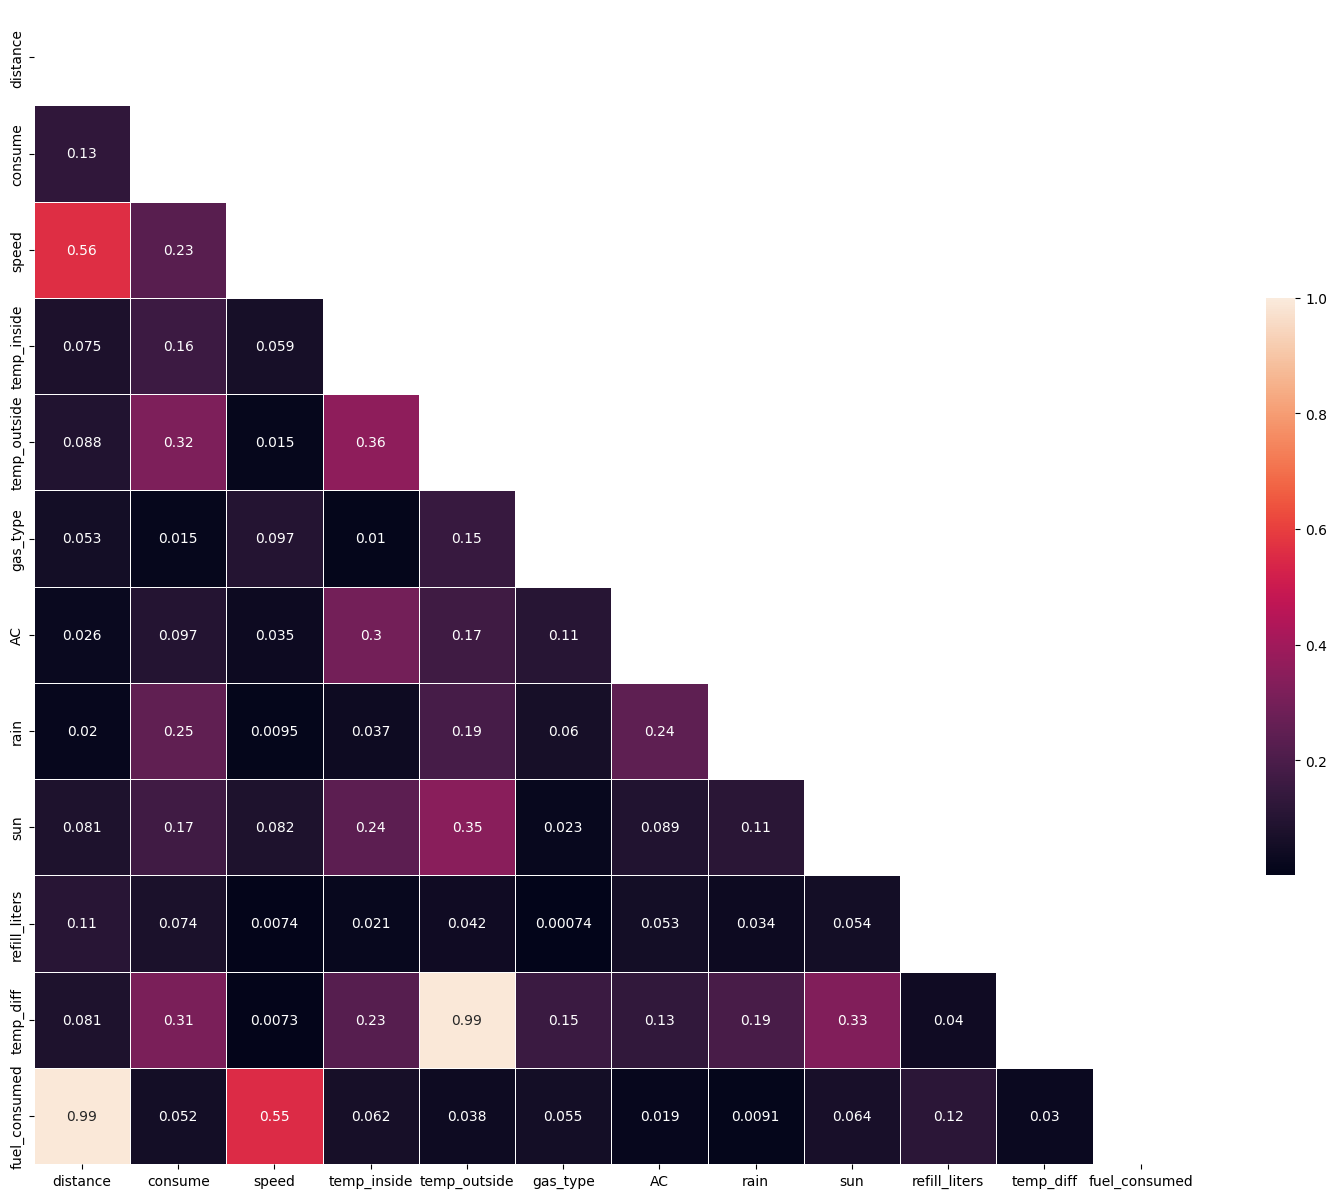

In [86]:
corr_tri_map(data)

<Axes: >

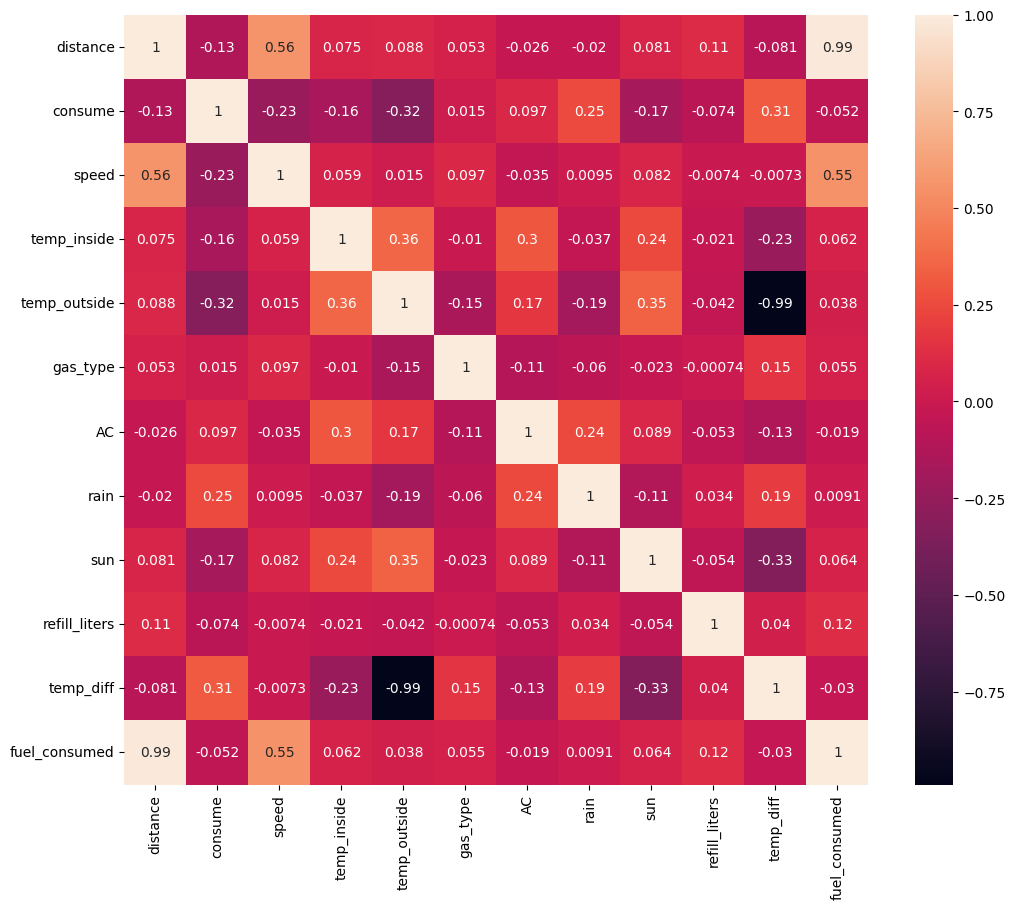

In [87]:
# Encode gas type for heat map
data['gas_type'] = np.where(data['gas_type']=='E10',1,0)
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), annot=True)

In [88]:
## because of collinearity, temp_diff and fuel_consumed need to be dropped
data = data.drop(['temp_diff', 'fuel_consumed'],axis=1)

In [89]:
data.isna().sum()

distance         0
consume          0
speed            0
temp_inside      0
temp_outside     0
gas_type         0
AC               0
rain             0
sun              0
refill_liters    0
dtype: int64

In [102]:
def get_transformed(data, transformer):
    data_norm = transformer.transform(data)

    return pd.DataFrame(data_norm, index=data.index, columns=data.columns)

def train_data(df):
    X, y = data.drop('consume',axis=1), data['consume']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=SEED)

    X_train_num = X_train.select_dtypes(include='number')
    X_train_cat = X_train.select_dtypes(include="object")
    X_test_num = X_test.select_dtypes(include='number')
    X_test_cat = X_test.select_dtypes(include="object")

    # Scale and Encode data
    transformer = MinMaxScaler().fit(X_train_num)

    X_train_scaled = get_transformed(X_train_num, transformer)
    X_test_scaled = get_transformed(X_test_num, transformer)

    X_train = pd.concat([X_train_scaled, X_train_cat],axis=1)
    X_test = pd.concat([X_test_scaled, X_test_cat],axis=1)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_data(data)

In [103]:
#  Eval model function
def eval_model(model, X_test_data, y_test_labels, get_metrics:bool=False):
    pred = model.predict(X_test_data)

    mae = mean_absolute_error(pred, y_test_labels)
    rmse = mean_squared_error(pred, y_test_labels, squared=False)
    r2 = model.score(X_test_data, y_test_labels)

    print("MAE: ", mae)
    print("RMSE: ", rmse)
    print("R2 Score: ", r2)
    print('-'*45)

    if get_metrics:
        return mae, rmse, r2

def test_model(model, train_data, train_labels, test_data, test_labels):
    # fit model to data
    model.fit(train_data, train_labels)
    # Test performance
    eval_model(model, test_data, test_labels)

def model_metrics(model, train_data, test_data, train_labels, test_labels, model_name:str='Model'):
    model.fit(train_data, train_labels)
    # Test performance
    mae, rmse, r2 = eval_model(model, test_data, test_labels, get_metrics=True)

    # Perform cross-validation and calculate mean cross-validated MAE
    cv_mae = -cross_val_score(model, train_data, train_labels, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1).mean()

    # Get dataframe
    metrics_df = pd.DataFrame({
    'Model': model_name,
    'MAE': mae,
    'RMSE': rmse,
    'R2 Score': r2,
    'Cross-validated MAE': cv_mae
    }, index = [0])

    return metrics_df


In [104]:
lin_model = LinearRegression()

model_metrics(lin_model, X_train, X_test, y_train, y_test, model_name='Linear_Regression')

MAE:  0.6523775098125141
RMSE:  0.896556574248953
R2 Score:  0.11406554378968559
---------------------------------------------


,Model,MAE,RMSE,R2 Score,Cross-validated MAE
0,Linear_Regression,0.652378,0.896557,0.114066,0.654469


In [107]:
def run_models(models, X_train, X_test, y_train, y_test):
    for model in models:
        name = f"{model.__class__.__name__}"
        res = model_metrics(model, X_train, X_test, y_train, y_test, model_name=name)
        print(res, end='\n'+'-'*50+'\n')

test_models = [KNeighborsRegressor(), DecisionTreeRegressor(), BaggingRegressor(), RandomForestRegressor()]
run_models(test_models,X_train, X_test, y_train, y_test)

MAE:  0.5958974358974359
RMSE:  0.9016452198975506
R2 Score:  0.1039802900336052
---------------------------------------------
                 Model       MAE      RMSE  R2 Score  Cross-validated MAE
0  KNeighborsRegressor  0.595897  0.901645   0.10398              0.61329
--------------------------------------------------
MAE:  0.5737179487179487
RMSE:  1.0102202095557542
R2 Score:  -0.12480774630664548
---------------------------------------------
                   Model       MAE     RMSE  R2 Score  Cross-validated MAE
0  DecisionTreeRegressor  0.573718  1.01022 -0.124808             0.632742
--------------------------------------------------
MAE:  0.44431623931623915
RMSE:  0.6665582711023309
R2 Score:  0.5103086445473022
---------------------------------------------
              Model       MAE      RMSE  R2 Score  Cross-validated MAE
0  BaggingRegressor  0.444316  0.666558  0.510309             0.491159
--------------------------------------------------
MAE:  0.433980616605617

### Best r2 score was RandomForestRegressor